# Coursework 3

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Self consistent fields - Water

Perform the self-consistent field calculation for a water molecule, $\text{H}_2\text{O}$.

### Plotting

There is useful information contained in the basis functions. The calculations here used the *STO-3G* basis, which are Gaussians with carefully chosen coefficients. There is one basis function per atomic orbital: so one for each hydrogen (the "1s" orbital) and five for the oxygen (one for the "1s" orbital, one for the "2s" orbital, and three for the "2p" orbitals - one for each Cartesian direction, associated with the quantum spins). Each basis function is written
$$
  \tilde{\chi} (r) = \sum_{i=1}^3 c_{i} \left( \frac{2 \alpha_i}{\pi} \right)^{3/4} e^{-\alpha_i r^2},
$$
where $r$ is the distance to the nucleus of this particular atom, and the $c_i, \alpha_i$ coefficients depend on the atom and the orbital.

For the "1s" orbitals the values of the coefficients are
$$
\begin{align}
  c_1 &= 0.444635, & c_2 &= 0.535328, & c_3 &= 0.154329, \\
  \alpha_1 &= 0.109818 \zeta_1^2, & \alpha_2 &= 0.405771 \zeta_1^2, & \alpha_3 &= 2.22766 \zeta_1^2.
\end{align}
$$
Here $\zeta_1 = 1.24$ for hydrogen and $\zeta_1 = 7.66$ for oxygen.

For the "2s" orbital the coefficients are
$$
\begin{align}
  c_1 &= 0.700115, & c_2 &= 0.399513, & c_3 &= -0.0999672, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$
Here $\zeta_2 = 2.25$ for oxygen.

Finally, for the "2p" orbital, the coefficients are
$$
\begin{align}
  c_1 &= 0.391957, & c_2 &= 0.607684, & c_3 &= 0.1559163, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$

In the above matrices, the seven entries correspond to:
$$
\begin{align}
  0 &: \text{Oxygen, 1s}, \\
  1 &: \text{Oxygen, 2s}, \\
  2 &: \text{Oxygen, 2p (x)}, \\
  3 &: \text{Oxygen, 2p (y)}, \\
  4 &: \text{Oxygen, 2p (z)}, \\
  5 &: \text{Hydrogen (1), 1s}, \\
  6 &: \text{Hydrogen (2), 1s}.
\end{align}
$$

### Constructing the full molecular orbitals

Given these basis functions, the single orbital molecular orbitals can be constructed as
$$
  \chi_i = \sum_{\mu=1}^K C_{i\mu} \tilde{\chi}_{\mu}.
$$
The iso-surfaces of the molecular orbitals give useful information about the reaction properties of the molecule.

### Tasks

1. Compute the total energy using the self-consistent field method. Ensure that your code prints the energy to the screen and returns the basis coefficients $C$ for later use.
2. Construct the molecular orbitals and plot isocontours of each in the $x-y$ plane.

In [1]:
import pytest
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# =============================================================================
# Hartree-Fock Algorithm Functions
# =============================================================================

def transformation_matrix(S):
    """
    Compute the transformation matrix given the overlap matrix S.

    Parameters
    ----------
    S: (n orbitals x n orbitals) array of floats.
        An array containing the coefficents for the overlap matrix.

    Returns
    -------
    X: (n orbitals x n orbitals) array of floats.
        The transformation matrix given by the eigenvectors and eigenvalues
        of the overlap matrix S.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form
    assert(np.all(np.isfinite(S))), 'The entries of S are not finite.'
    assert(S.shape[0] > 0), 'C has no entries.'
    assert(S.shape[0] == S.shape[1]), 'S is not square.'

    eigvals, eigvecs = np.linalg.eig(S)
    X = np.dot(eigvecs, np.dot(np.diag(eigvals ** (-0.5)),
                               np.conj(np.transpose(eigvecs))))

    return X


def density_matrix(C, n_electrons):
    """
    Compute the density matrix given the coefficents of the molecular orbit
    basis coefficents.

    Parameters
    ----------
    C: (n orbitals x n orbitals) array of floats.
        The coefficents for the molecular orbit basis functions.
    n_electrons: int.
        The number of electrons in the system.

    Returns
    -------
    D: (n orbitals x n orbitals) array of floats.
        The density matrix of the system.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form
    assert(np.all(np.isfinite(C))), 'The entries of C are not finite.'
    assert(C.shape[0] > 0), 'C has no entries.'
    assert(C.shape[0] == C.shape[1]), 'C is not square.'

    assert(np.isfinite(n_electrons)), 'n_electrons is not finite.'
    assert(type(n_electrons) == int), \
        'The number of electrons is an int amount.'
    if n_electrons <= 0:
        raise ValueError('The number of electrons is positive and non-zero.')

    D = np.zeros_like(C)
    n = C.shape[0]

    for mu in range(n):
        for nu in range(n):
            for j in range(n_electrons//2):  # use int division
                D[mu, nu] += 2 * C[mu, j] * C[nu, j]

    return D


def flock_matrix(H, G, D):
    """
    Compute the Flock matrix of the system given the one-electron integral
    matrix H, the two-electron integrals matrix G and the density matrix D.

    Parameters
    ----------
    H: (n orbitals x n orbitals) array of floats.
        The one-electron integral coefficent matrix.
    G: (n orbitals x n orbialts x n orbitals x n orbitals) array of floats.
        The two-electron integral coefficent matrix.
    D: (n orbitals x n orbitals) array of floats.
        The density matrix for the system.

    Returns
    -------
    F: (n orbitals x n orbitals) array of floats.
        The Flock matrix for the system.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form, kind of a weak check as the rows
    # could be correct, but the columns incorrect :-( 
    assert(H.shape[0] == G.shape[0] == D.shape[0]), \
        'The array shapes are not compatiable.'
  
    assert(np.all(np.isfinite(H))), 'The entries of H are not finite.'
    assert(H.shape[0] > 0), 'H has no entries.'
    assert(H.shape[0] == H.shape[1]), 'H is not square.'

    assert(np.all(np.isfinite(G))), 'The entries of G are not finite.'
    assert(G.shape[0] > 0), 'G has no entries.'
    assert(G.shape[0] == G.shape[1] == G.shape[2] == G.shape[3]), \
        'G has incorrect dimensions.'

    assert(np.all(np.isfinite(D))), 'The entries of D are not finite.'
    assert(D.shape[0] > 0), 'D has no entries.'
    assert(D.shape[0] == D.shape[1]), 'D is not square.'

    F = np.zeros_like(H)
    n = F.shape[0]

    # set the elements of F to be H, makes the next bit of the code smaller
    # as F = H + G * D
    F[:, :] = H[:, :]
    assert(np.all(F) == np.all(H)), \
        'Value of H have not been assigned to F properly.'

    for mu in range(n):
        for nu in range(n):
            for alpha in range(n):
                for beta in range(n):
                    F[mu, nu] += (G[mu, nu, alpha, beta] - 0.5 *
                                  G[mu, beta, alpha, nu]) * D[alpha, beta]

    return F


def orbital_values(F, X):
    """
    Diagonalise the Flock matrix and compute the oribal energies (eigenvalues),
    and the coefficents of the molecular orbitals basis functions
    (eigenvectors).

    Parameters
    ----------
    F: (n orbitals x n orbitals) array of floats.
        The Flock matrix for the system.
    X: (n orbitals x n orbitals) array of floats.
        The transformation matrix.

    Returns
    -------
    orb_eng: (n orbials x 1) array of floats.
        The eigenvalues of the diagonalised Flock matrix.
    C: (n orbitals x n orbitals) array of floats.
        The eigenvectors of the diagonalised Flock matrix, which are the
        coefficents for the molecular orbits basis functions.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form
    assert(np.all(np.isfinite(F))), 'The entries of F are not finite.'
    assert(F.shape[0] > 0), 'F has no entries.'
    assert(F.shape[0] == F.shape[1]), 'F is not square.'

    assert(np.all(np.isfinite(X))), 'The entries of G are not finite.'
    assert(X.shape[0] > 0), 'X has no entries.'
    assert(X.shape[0] == X.shape[1]), 'X is not square.'

    # diagonalise the Flock matrix
    Fprime = np.dot(np.conj(np.transpose(X)), np.dot(F, X))
    eigvals, eigvecs = np.linalg.eigh(Fprime)

    # putting the eigenvalues and eigenvectors into the correct order by
    # sorting the eigenvalues from smallest to largest and remembering to
    # rearrange the eigenvectors as well
    idx = eigvals.argsort()
    orb_eng = eigvals[idx]
    orb_coefs = eigvecs[:, idx]

    assert(orb_eng.shape == eigvals.shape), 'Eigenvalue have been lost!'
    assert(orb_coefs.shape == eigvecs.shape), 'Eigenvectors have been lost!'

    C = np.dot(X, orb_coefs)

    return orb_eng, C


def HF_step(X, H, G, C, D, n_electrons):
    """
    The set of steps required to compute a step using the Hartree-Fock method.
    The function will take in the number of electrons, the density matrix,
    the transformation matrix, the molecular orbit coefficent matrix and the
    electron integral matrcies.

    These are used to compute the Fock matrix of the system and then update the
    molecular orbit coefficents and new density matrix.

    Parameters
    ----------
    X: (n orbitals x n orbitals) array of floats.
        The transformation matrix.
    H: (n orbitals x n orbitals) array of floats.
        The one-electron integral coefficent matrix.
    G: (n orbitals x n orbialts x n orbitals x n orbitals) array of floats.
        The two-electron integral coefficent matrix.
    D: (n orbitals x n orbitals) array of floats.
        The density matrix for the system.
    C: (n orbitals x n orbitals) array of floats.
        The coefficents for the molecular orbit basis functions.
    n_electrons: int.
        The number of electrons in the system.

    Returns
    -------
    new_D: (n orbitals x n orbitals) array of floats.
        The updated density matrix of the system.
    orb_eng: (n orbitals x 1) array of floats.
        The eigenvalues of the diagonalised Flock matrix.
    new_C: (n orbitals x n orbitals) array of floats.
        The updated coefficents for the molecular orbit basis functions.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form
    assert(np.all(np.isfinite(X))), 'The entries of G are not finite.'
    assert(X.shape[0] > 0), 'X has no entries.'
    assert(X.shape[0] == X.shape[1]), 'X is not square.'

    assert(np.all(np.isfinite(H))), 'The entries of H are not finite.'
    assert(H.shape[0] > 0), 'H has no entries.'
    assert(H.shape[0] == H.shape[1]), 'H is not square.'

    assert(np.all(np.isfinite(G))), 'The entries of G are not finite.'
    assert(G.shape[0] > 0), 'G has no entries.'
    assert(G.shape[0] == G.shape[1] == G.shape[2] == G.shape[3]), \
        'G has incorrect dimensions.'

    assert(np.all(np.isfinite(D))), 'The entries of D are not finite.'
    assert(D.shape[0] > 0), 'D has no entries.'
    assert(D.shape[0] == D.shape[1]), 'D is not square.'

    assert(np.all(np.isfinite(C))), 'The entries of C are not finite.'
    assert(C.shape[0] > 0), 'C has no entries.'
    assert(C.shape[0] == C.shape[1]), 'C is not square.'

    assert(np.isfinite(n_electrons)), 'n_electrons is not finite.'
    assert(type(n_electrons) == int), \
        'The number of electrons is an int amount.'
    if n_electrons <= 0:
        raise ValueError('The number of electrons is positive and non-zero.')

    F = flock_matrix(H, G, D)
    orb_eng, new_C = orbital_values(F, X)
    new_D = density_matrix(new_C, n_electrons)

    return new_D, orb_eng, new_C


def total_energy(D, H, F, Vnn):
    """
    Compute the total energy of the system using the density matrix D, the
    flock matrix F, the one-electron integral H and the nucleon repulsion
    energy.

    Parameters
    ----------
    D: (n orbitals x n orbitals) array of floats.
        The density matrix for the system.
    H: (n orbitals x n orbitals) array of floats.
        The one-electron integral coefficent matrix.
    F: (n orbitals x n orbitals) array of floats.
        The Flock matrix of the system.
    Vnn: float.
        The value of the nucleon repulsion energy of the system.

    Returns
    -------
    Etot: float.
        The total energy of the system.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form
    assert(np.all(np.isfinite(D))), 'The entries of D are not finite.'
    assert(D.shape[0] > 0), 'D has no entries.'
    assert(D.shape[0] == D.shape[1]), 'D is not square.'

    assert(np.all(np.isfinite(H))), 'The entries of H are not finite.'
    assert(H.shape[0] > 0), 'H has no entries.'
    assert(H.shape[0] == H.shape[1]), 'H is not square.'

    assert(np.all(np.isfinite(F))), 'The entries of F are not finite.'
    assert(F.shape[0] > 0), 'F has no entries.'
    assert(F.shape[0] == F.shape[1]), 'F is not square.'

    assert(np.isfinite(Vnn)), 'Vnn is not finite.'
    assert(type(Vnn) is float or int), 'Vnn is of type float or int.'

    n = D.shape[0]

    # set Etot as Vnn as the total energy of the system includes the nucelon
    # repulsion energy
    Etot = Vnn
    assert(Etot == Vnn), 'Vnn is not being added to Etot properly.'
    for mu in range(n):
        for nu in range(n):
            Etot += 0.5 * D[mu, nu] * (H[mu, nu] + F[mu, nu])

    return Etot


def matrix_diff(D, DNew):
    """
    Calculate the difference between two density matrices. In this case
    the difference between an old and updated density matrix.

    Parameters
    ----------
    D: (n orbitals x n orbitals) array of floats.
        The old density matrix of the system.
    DNew: (n orbitals x n orbitals) array of floats.
        The updated density matrix of the system.

    Returns
    -------
    difference: float.
        The difference between the two density matrices.
    """

    assert(D.shape == DNew.shape), \
        'The densitry matrices are different sizes.'

    n = D.shape[0]

    # loop over each element of the matrices and subtract the elements
    difference = 0
    for mu in range(n):
        for nu in range(n):
            difference += (D[mu, nu] - DNew[mu, nu]) ** 2

    difference = np.sqrt(difference)

    return difference


def HF_iteration(S, H, G, C, Vnn, n_electrons, tol=1e-6):
    """
    Iterates the given matrices using the Hatree-Fock method until the
    density matrix converges to a given tolerence. Converge is calculated by
    calculating the difference between the old and updated density matrix
    for each iteration.

    Parameters
    ----------
    S: (n orbitals x n orbitals) array of floats.
        An array containing the coefficents for the overlap matrix.
    H: (n orbitals x n orbitals) array of floats.
        The one-electron integral coefficent matrix.
    G: (n orbitals x n orbialts x n orbitals x n orbitals) array of floats.
        The two-electron integral coefficent matrix.
    C: (n orbitals x n orbitals) array of floats.
        The coefficents for the molecular orbit basis functions.
    Vnn: float.
        The value of the nucleon repulsion energy of the system.
    tol: float.
        The tolerance used to determine when the system has converged, by
        default this is 1e-6.

    Returns
    -------
    Etot: float.
        The total energy of the system, including the nuclear repulsion energy.
    C: (n orbitals x n orbitals) array of floats.
        The coefficents for the molecular orbits once the system has converged.
    OE: (1 x n orbitals) array of floats.
        The energies of each molecular orbit.
    """

    # for each matrix:
    # check that the elements are finite, that there are elements and that
    # the matrix is in the correct form
    assert(np.all(np.isfinite(S))), 'The entries of S are not finite.'
    assert(S.shape[0] > 0), 'C has no entries.'
    assert(S.shape[0] == S.shape[1]), 'S is not square.'

    assert(np.all(np.isfinite(H))), 'The entries of H are not finite.'
    assert(H.shape[0] > 0), 'H has no entries.'
    assert(H.shape[0] == H.shape[1]), 'H is not square.'

    assert(np.all(np.isfinite(G))), 'The entries of G are not finite.'
    assert(G.shape[0] > 0), 'G has no entries.'
    assert(G.shape[0] == G.shape[1] == G.shape[2] == G.shape[3]), \
        'G has incorrect dimensions.'

    assert(np.all(np.isfinite(C))), 'The entries of C are not finite.'
    assert(C.shape[0] > 0), 'C has no entries.'
    assert(C.shape[0] == C.shape[1]), 'C is not square.'

    # check there are the correct number of electrons, i.e. there has to be
    # at least one and that it is an int amount
    assert(np.isfinite(n_electrons)), 'n_electrons is not finite.'
    assert(type(n_electrons) == int), \
        'The number of electrons is an int amount.'
    if n_electrons <= 0:
        raise ValueError('The number of electrons is positive and non-zero.')

    assert(np.isfinite(Vnn)), 'Vnn is not finite.'
    assert(type(Vnn) is float or int), 'Vnn is of type float or int.'

    if tol <= 0:
        raise ValueError('The tolerance has the be positive and non-zero.')
    
    X = transformation_matrix(S)
    D = density_matrix(C, n_electrons)

    # set diff to be large otherwise the while loop would stop immediately
    diff = 10 * tol
    current_iteration = 0
    max_iteration = 100

    # continue to iterate the system until it converges, i.e. when the
    # difference between D and DNew is less than or equal to the tolerence
    while (diff > tol) and (current_iteration < max_iteration):
        current_iteration += 1
        DNew, orb_engs, C = HF_step(X, H, G, C, D, n_electrons)
        diff = matrix_diff(D, DNew)
        D = DNew

    if (diff < tol):
        F = flock_matrix(H, G, D)
        Etot = total_energy(D, H, F, Vnn)
        print('Total energy: {:3.3f} Hartrees\nIterations: {}'
              .format(Etot, current_iteration))

    else:
        print('Ruh-roh, failed to converge!')

        # if the sytem doesn't converge, return None
        Etot = C = orb_engs = None

    return Etot, C, orb_engs


# =============================================================================
# Constructing the Basis Fuctions & Molecular Orbits
# =============================================================================

def basis(R, a, c):
    """
    Calculate the value of the STO-3G basis function at a given distance
    r from a nucelus.
    
    (This function used to be embedded in basis_functions, but was placed here
    instead for testing purposes.)

    Parameters
    ----------
    R: float.
        The distance between a point in space and the nucleus of the orbit.
    a: (1 x 3) array of floats.
        The a coefficents for the orbit for the STO-3G basis functions.
    c: (1 x 3) array of floats.
        The c coefficents for the orbit for the ST0-3G basis functions.

    Returns
    -------
    chi: float.
        The value of the basis function at the distance R from the nucelus.
    """

    assert(type(R) is float or int), 'R is of type float or int.'
    assert(a.size == 3), 'Incorrect number of a coefficents supplied.'
    assert(c.size == 3), 'Incorrect number of c coefficents supplied.'

    n_phi = 3  # number of gaussians making up the basis function

    chi = 0  # iterate through each value of a, c, and xi
    for i in range(n_phi):
        chi += c[i] * (((2 * a[i])/np.pi) ** (3/4)) * \
            np.exp(-(a[i]) * R ** 2)

    return chi


def basis_functions(R, C):
    """
    Construct the basis functions for an orbital for a given distance R from
    the nucelus. The function will output the orbital basis functions as:
        Entry 1: Oxygen 1s
        Entry 2: Oxygen 2s
        Entry 3: Oxygen 2p (x)
        Entry 4: Oxygen 2p (y)
        Entry 5: Oxygen 2p (z)
        Entry 6: Hydrogen 1 1s
        Entry 7: Hydorgen 2 1s

    Parameters
    ----------
    R: (1 x n orbitals) array of floats.
        The distance from a point in space to the nucleus of the orbital.
    C: (n orbitals x n orbitals) array of floats.
        The coefficents for the molecular orbit basis functions. Used to figure
        out the number of orbitals.
        
    Returns
    -------
    basis_functions: (1 x n_orbitals) array of floats.
        The value of the basis functions for the orbitals at a position in
        space R.
    """
    
    n_orbitals = C.shape[0]
    assert(R.size == n_orbitals), \
        'There are not the same amount of orbitals and distances'

    # the values for xi for the atom orbitals
    xi1_H = 1.24 ** 2
    xi1_O = 7.66 ** 2
    xi2_O = 2.25 ** 2

    # the a coefficents in order of the orbitals given
    a = np.array(
        [[0.1098180 * xi1_O, 0.405771 * xi1_O, 2.227660 * xi1_O],
         [0.7513860 * xi2_O, 0.231031 * xi2_O, 0.994203 * xi2_O],
         [0.0751386 * xi2_O, 0.231031 * xi2_O, 0.994203 * xi2_O],
         [0.0751386 * xi2_O, 0.231031 * xi2_O, 0.994203 * xi2_O],
         [0.0751386 * xi2_O, 0.231031 * xi2_O, 0.994203 * xi2_O],
         [0.1098180 * xi1_H, 0.405771 * xi1_H, 2.227660 * xi1_H],
         [0.1098180 * xi1_H, 0.405771 * xi1_H, 2.227660 * xi1_H]])

    # the c coefficents in order of the orbitals given
    c = np.array(
        [[0.444635, 0.535328, 0.1543290],
         [0.700115, 0.399513, -0.999672],
         [0.391957, 0.607684, 0.1559163],
         [0.391957, 0.607684, 0.1559163],
         [0.391957, 0.607684, 0.1559163],
         [0.444635, 0.535328, 0.1543290],
         [0.444635, 0.535328, 0.1543290]])

    # construct the basis functions for an orbital
    basis_functions = np.zeros(n_orbitals)
    for mu in range(n_orbitals):
        basis_functions[mu] = basis(R[mu], a[mu, :], c[mu, :])

    return basis_functions


def molecular_orbits(C, r):
    """
    Compute the molecular orbit value at a point r in the x-y plane. This
    is done for all the orbitals of the system. The function will assumes
    and outputs the molecular orbits functions as:
        Entry 1: Oxygen 1s
        Entry 2: Oxygen 2s
        Entry 3: Oxygen 2p (x)
        Entry 4: Oxygen 2p (y)
        Entry 5: Oxygen 2p (z)
        Entry 6: Hydrogen 1 1s
        Entry 7: Hydorgen 2 1s

    Parameters
    ----------
    C: (n orbitals x n orbitals) array of floats.
        The coefficents for the molecular orbital basis functions.
    r: (1 x 3) array of floats.
        A position in space on the x-y plane. The z-coordinate is required,
        but this should be set to 0.

    Returns
    -------
    MO: (1 x n orbitals) array of floats.
        The value of the molecular orbit function at a point r in the x-y
        plane.
    """

    assert(np.all(np.isfinite(C))), 'The entries of C are not finite.'
    assert(C.shape[0] > 0), 'C has no entries.'
    assert(C.shape[0] == C.shape[1]), 'C is not square.'

    assert(np.all(np.isfinite(r))), 'r is not finite.'
    assert(r.size == 3), 'r has to be a 3D vector.'

    n_orbitals = C.shape[0]

    # define the positions of the oxygen and hydrogen nuceli (in 3D)
    R_O1 = np.array([0.0, +1.809 * np.cos(104.52/180.0 * np.pi/2.0), 0.0])
    R_H1 = np.array([-1.809 * np.sin(104.52/180.0 * np.pi/2.0), 0.0, 0.0])
    R_H2 = np.array([+1.809 * np.sin(104.52/180.0 * np.pi/2.0), 0.0, 0.0])

    # calculate the separations
    rO = r - R_O1  # calculate this once
    rH1 = r - R_H1
    rH2 = r - R_H2
    coord_sep = np.array([rO, rO, rO, rO, rO, rH1, rH2])
    # use linalg.norm to calculate the distance
    R = np.linalg.norm(coord_sep, axis=1)

    # finally calculate the molecular orbits for all the orbitals
    MO = np.zeros(n_orbitals)
    basis = basis_functions(R, C)
    for orb in range(n_orbitals):
        for mu in range(n_orbitals):
            MO[orb] += C[orb, mu] * basis[mu]

    return MO

# "Unit Tests"

In [3]:
def function_tests(msg=False):
    """
    The function containing all of the function tests. Works best used with
    pytest.
    
    Parameters
    ----------
    msg: bool.
        If msg is True, a message will be printed to the screen if the test
        has passed. Otherwise, if it is False, no message will be printed.
    """
    
    if msg is True:
        print('#### beginning tests ####\n')
    
    def test_transformation_matrix(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        # expect an error if the S array is not square or has no elements
        S = np.zeros((1, 4))
        S1 = np.array([])  # empty array
        with pytest.raises(AssertionError):
            transformation_matrix(S)
            transformation_matrix(S1)

        # the output should be the same shape as the input
        S = np.ones((7, 7))
        X = transformation_matrix(S)
        assert(X.shape == S.shape)

        if msg is True:
            print('transformation_matrix testing passed.')


    def test_density_matrix(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        n_electrons = 10
        C = np.zeros((7, 7))
        C1 = np.zeros((1, 7))
        C2 = np.array([])
        with pytest.raises(AssertionError):
            density_matrix(C, 10.5)          # n_electrons is not an int
            density_matrix(C1, n_electrons)  # array not square
            density_matrix(C2, n_electrons)  # array has no elements

        # test for bad input for n_electrons returns an error
        with pytest.raises(ValueError):
            density_matrix(C, 0)    # has to be some electrons
            density_matrix(C, -1)   # negative electrons makes no sense

        # the output has to be the same shape as the array input
        D = density_matrix(C, n_electrons)
        assert(D.shape == C.shape)

        if msg is True:
            print('density_matrix testing passed.')


    def test_flock_matrix(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        H = np.zeros((7, 7))
        G = np.zeros((7, 7, 7, 7))
        D = np.zeros_like(H)
        H1 = np.zeros((1, 7))
        G1 = np.zeros_like(H1)
        D1 = np.zeros_like(H1)

        with pytest.raises(AssertionError):
            flock_matrix(H, G, D1)  # the arrays are different sizes
            flock_matrix(H1, G, D)  # arrays are not the correct shape
            flock_matrix(H, G1, D)

        # the output should be the same size as H and D
        F = flock_matrix(H, G, D)
        assert(H.shape == F.shape)

        if msg is True:
            print('flock_matrix testing passed.')


    def test_orbital_values(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        F = np.zeros((7, 7))
        X = np.zeros_like(F)
        F1 = np.zeros((1, 7))
        X1 = np.zeros_like(F1)
        with pytest.raises(AssertionError):
            orbital_values(F1, X)  # test that an error is returned for bad shapes
            orbital_values(F, X1)

        # OE should be (1 x n orbitals (7)) and C should be the same shape as input
        OE, C = orbital_values(F, X)
        assert(OE.shape[0] == 7)
        assert(C.shape == F.shape)

        # check to make sure the orbital engeries are ordered correctly. Use random
        # values to test this
        F = np.random.rand(7, 7)
        X = np.random.rand(7, 7)
        OE, C = orbital_values(F, X)
        for i in range(6):
            assert(OE[i] < OE[i+1])

        if msg is True:
            print('orbital_values testing passed.')


    def test_HF_step(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        X = np.zeros((7, 7))
        H = np.zeros_like(X)
        G = np.zeros((7, 7, 7, 7))
        C = np.zeros_like(X)
        D = np.zeros_like(X)
        n_electrons = 11

        # some of the output should be the same size as the input arrays and one
        # should be a 1D vector
        nD, OE, nC = HF_step(X, H, G, C, D, n_electrons)
        assert(nD.shape == D.shape)
        assert(nC.shape == C.shape)
        assert(OE.shape[0] == 7)


    def test_total_energy(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        D = np.random.rand(7, 7)
        H = np.random.rand(7, 7)
        F = np.random.rand(7, 7)
        Vnn = 10

        # the output of this will be a float (or an int)
        E = total_energy(D, H, F, Vnn)
        assert(type(E) is int or float)

        # if Vnn is non-zero, the total energy should be Vnn when all the other
        # inputs are zero
        D = np.zeros((7, 7))
        H = np.zeros_like(D)
        F = np.zeros_like(D)
        E = total_energy(D, H, F, Vnn)
        assert(E == Vnn)

        if msg is True:
            print('total_energy testing passed.')

            
    def test_matrix_diff(msg=False):
        """
        Testing the matrix difference function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        D = np.zeros((7, 7))
        nD = np.ones((7, 7))
        nD1 = np.ones((1, 7))

        # an error should be returned if the arrays are different shapes
        with pytest.raises(AssertionError):
            matrix_diff(D, nD1)

        # using the new D as an array of 1s and the old D as zeros, should expect
        # for 7 to be returned
        diff = matrix_diff(D, nD)
        assert(type(diff) is float or int)  # it has to be a float or int!
        assert(diff == 7)

        if msg is True:
            print('matrix diff testing passed.')
         
        
    def test_HF_iteration(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        # use a system which we know the value of and will converge
        n_electrons = 2
        S = np.array([[1.0, 0.434311], [0.434311, 1.0]])
        H = np.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
        G = np.array([[[[0.77460594, 0.27894304], [0.27894304, 0.52338927]],
                     [[0.27894304, 0.14063907], [0.14063907, 0.34321967]]],
                     [[[0.27894304, 0.14063907], [0.14063907, 0.34321967]],
                      [[0.52338927, 0.34321967], [0.34321967, 1.05571294]]]])
        C = np.zeros_like(S)
        Vnn = 1.3668670357
             
        # given a larger tolerence, it should converge
        E, C, OE = HF_iteration(S, H, G, np.zeros_like(S), Vnn, n_electrons)
        assert(np.isclose(E, -2.626133045))
        
        # C should be the same shape as S and OE should be 1 x n orbitals
        assert(C.shape == S.shape)
        assert(OE.shape[0] == 2)
        
        """
        # use a very small tolerance on a random system where it should reach the max
        # number of iterations. If the max number of iterations are reached, the
        # function will stop and return None.
        # SOMETIMES THIS WILL CONVERGE AAAAAA OR BREAK IN OTHER WAYS AAAAAAAAA
        S = np.random.rand(2, 2)
        H = np.random.rand(2, 2)
        G = np.random.rand(2, 2, 2, 2)
        C = np.zeros_like(S)
        E, C, OE = HF_iteration(S, H, G, C, Vnn, n_electrons, 10e-40)
        assert(E is None)
        """
        
        if msg is True:
            print('HF_iteration testing passed.')
            

    def test_basis(msg=False):
        """
        Testing the basis function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test has
            passed. Otherwise, it if is False, no message will be printed.
        """

        # the input will be some floats and arrays, but the output should be a
        # float. Check to make sure that is the case

        a = np.ones(3)
        c = np.ones(3)
        R = 1
        A = np.ones(4)  # incorrect formats
        C = np.ones(6)
        r = np.ones(2)

        # should be expecting errors due to incorrect format of the input
        with pytest.raises(AssertionError):
            basis(R, A, c)
            basis(R, a, C)
            basis(r, a, c)

        # the output should be a float or an int
        chi = basis(R, a, c)
        assert(type(chi) is float or int)
        # when R, a and c are all ones, chi is just the constants
        chi_calc = 3 * (1 * (((2 * 1)/np.pi) ** (3/4)) * np.exp(-(1) * 1 ** 2))
        assert(np.isclose(chi, chi_calc))

        if msg is True:
            print('basis testing passed.')
            
            
    def test_basis_functions(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        C = np.zeros((7, 7))
        R = np.zeros(7)
        R1 = np.zeros_like(C)

        # R1 is in the incorrect format so an error should be returned of this
        # is used
        with pytest.raises(AssertionError):
            basis_functions(R1, C)

        # the output should be a (1 x n orbitals) length array
        chis = basis_functions(R, C)
        assert(chis.size == C.shape[0])

        if msg is True:
            print('basis_functions testing passed.')
            

    def test_molecular_orbits(msg=False):
        """
        Testing the transformation matrix function.

        Parameters
        ----------
        msg: bool.
            If msg is True, a message will be printed to the screen if the test
            has passed. Otherwise, if it is False, no message will be printed.
        """

        r = np.ones(3)
        C = np.zeros((7, 7))
        R = np.ones(2)

        # whilst it makes sense to give a 2D vector for R, a 3D vector is required
        # thus an error should be returned when a 2E vector is given
        with pytest.raises(AssertionError):
            molecular_orbits(C, R)

        # the output should be a (1 x n orbitals) array
        MO = molecular_orbits(C, r)
        assert(MO.size == C.shape[0])

        if msg is True:
            print('molecular_orbits testing passed.')
            
            
    test_transformation_matrix(msg)
    test_density_matrix(msg)
    test_flock_matrix(msg)
    test_orbital_values(msg)
    test_HF_step(msg)
    test_total_energy(msg)
    test_matrix_diff(msg)
    test_HF_iteration(msg)  # this will print something :'(
    test_basis(msg)
    test_basis_functions(msg)
    test_molecular_orbits(msg)
    
    if msg is True:
        print('\n#### all tests passed ####')

msg = True
function_tests(msg)  # no idea where the division by zero is coming from

#### beginning tests ####

transformation_matrix testing passed.
density_matrix testing passed.
flock_matrix testing passed.
orbital_values testing passed.
total_energy testing passed.
matrix diff testing passed.
Total energy: -2.626 Hartrees
Iterations: 10
HF_iteration testing passed.
basis testing passed.
basis_functions testing passed.
molecular_orbits testing passed.

#### all tests passed ####


/Users/saultyevil/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in power
/Users/saultyevil/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in power


# Simulation Parameters for Water Molecule

In [25]:
Vnn = 8.90770810  # nucleon repulsion
Nelectrons = 10   # the number of electrons in the orbitals
G = np.fromfile('H2O-two-electron.dat')
G = np.reshape(G, (7, 7, 7, 7))  # two electron integrals

# overlap integral
S = np.array([[1, 0.2367039, 0,  0, -0, 0.0500137,  0.0500137],
              [0.2367039, 1,  0,  0, -0, 0.4539953,  0.4539953],
              [0,  0,  1,  0,  0, 0,  0],
              [0,  0,  0,  1,  0, 0.2927386, -0.2927386],
              [-0, -0,  0,  0,  1, 0.2455507,  0.2455507],
              [0.0500137, 0.4539953, 0, 0.2927386, 0.2455507, 1, 0.2510021],
              [0.0500137, 0.4539953, 0, -0.2927386, 0.2455507, 0.2510021, 1]])

# one electron integrals
H = np.array([[-3.26850823e+01, -7.60432270e+00, 0.00000000e+00,
               0.00000000e+00, -1.86797000e-02, -1.61960350e+00,
               -1.61960350e+00],
              [-7.60432270e+00, -9.30206280e+00, 0.00000000e+00,
               0.00000000e+00,  -2.22159800e-01, -3.54321070e+00,
               -3.54321070e+00],
              [0.00000000e+00, 0.00000000e+00, -7.43083560e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00],
              [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               -7.56702220e+00, 0.00000000e+00, -1.89085610e+00,
               1.89085610e+00],
              [-1.86797000e-02, -2.22159800e-01, 0.00000000e+00,
               0.00000000e+00, -7.52665570e+00, -1.65878930e+00,
               -1.65878930e+00],
              [-1.61960350e+00, -3.54321070e+00, 0.00000000e+00,
               -1.89085610e+00, -1.65878930e+00, -4.95649010e+00,
               -1.56026360e+00],
              [-1.61960350e+00, -3.54321070e+00, 0.00000000e+00,
               1.89085610e+00, -1.65878930e+00, -1.56026360e+00,
               -4.95649010e+00]])

# Calculate the Molecular Orbits

In [30]:
# calculate the energy of the system and MO coefficents
E, C, OE = HF_iteration(S, H, G, np.zeros_like(H), Vnn, Nelectrons, tol=1e-10)
n_orbitals = C.shape[0]

# create x-y plane of points
n_points = 500
x = np.linspace(-5, 5, n_points)
y = np.linspace(-5, 5, n_points)
X, Y = np.meshgrid(x, y)

# calculate the value of the MO function at each point in space
MO = np.zeros((n_orbitals, n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        r = np.array([X[i, j], Y[i, j], 0])
        MO[:, i, j] = molecular_orbits(C, r)

Total energy: -74.966 Hartrees
Iterations: 29


# Plotting the orbitals using contour plots

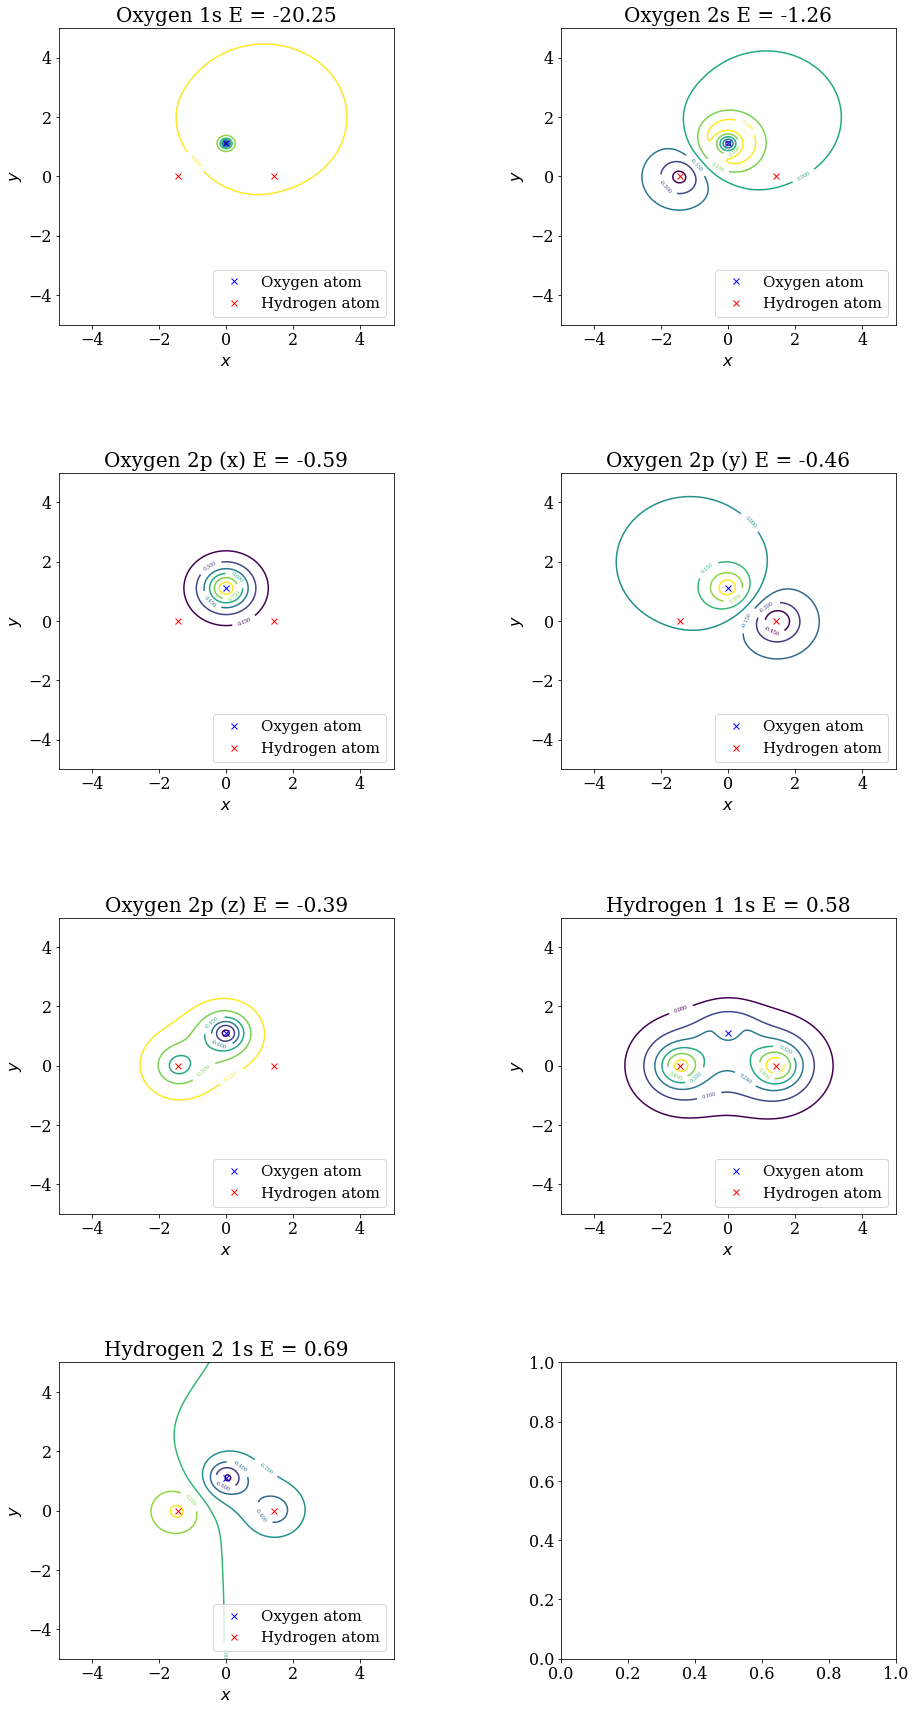

In [14]:
# define the nuclei positions for plotting and the subplot titles
R_O1 = np.array([0.0, +1.809 * np.cos(104.52/180.0 * np.pi/2.0), 0.0])
R_H1 = np.array([-1.809 * np.sin(104.52/180.0 * np.pi/2.0), 0.0, 0.0])
R_H2 = np.array([+1.809 * np.sin(104.52/180.0 * np.pi/2.0), 0.0, 0.0])
subplot_titles = ['Oxygen 1s E = {:1.2f}'.format(OE[0]),
                  'Oxygen 2s E = {:1.2f}'.format(OE[1]),
                  'Oxygen 2p (x) E = {:1.2f}'.format(OE[2]),
                  'Oxygen 2p (y) E = {:1.2f}'.format(OE[3]),
                  'Oxygen 2p (z) E = {:1.2f}'.format(OE[4]),
                  'Hydrogen 1 1s E = {:1.2f}'.format(OE[5]),
                  'Hydrogen 2 1s E = {:1.2f}'.format(OE[6])]

# plot the orbitals using a contour plot
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

for i in range(n_orbitals):
    ax[i].plot(R_O1[0], R_O1[1], 'bx', label='Oxygen atom')
    ax[i].plot(R_H1[0], R_H1[1], 'rx', label='Hydrogen atom')
    ax[i].plot(R_H2[0], R_H1[1], 'rx')
    CS = ax[i].contour(X, Y, MO[i, :, :])
    plt.clabel(CS, ax=ax[i], fontsize=5)
    ax[i].set_xlabel(r'$x$')
    ax[i].set_ylabel(r'$y$')
    ax[i].legend(loc='lower right', prop={'size': 15})
    ax[i].set_title(subplot_titles[i], fontsize=20)

plt.show()

# Plotting the orbitals using a colour map

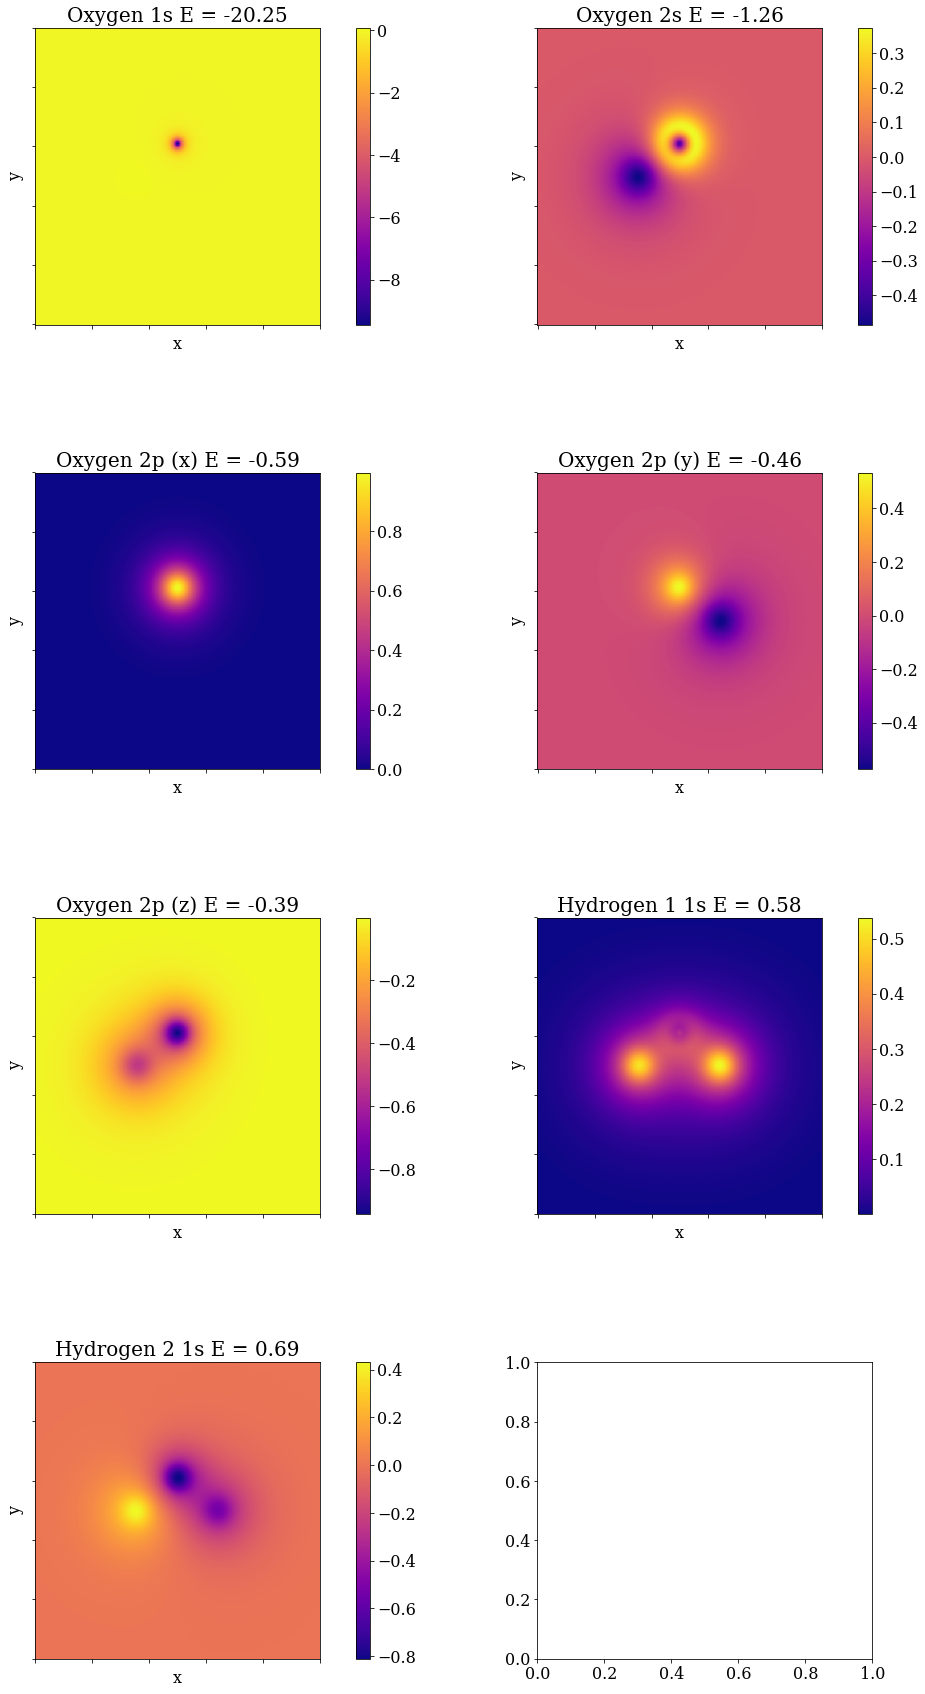

In [15]:
# plot the orbitals using a colourmap
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

for i in range(n_orbitals):
    im = ax[i].imshow(MO[i, :, :], cmap=plt.cm.plasma, aspect='auto', 
                      origin='lower')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.5)
    fig.colorbar(im, cax=cax)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].axes.xaxis.set_ticklabels([])
    ax[i].axes.yaxis.set_ticklabels([])
    ax[i].set_title(subplot_titles[i], fontsize=20)

plt.show()

# Discussion

*(Using the equation provided, the P orbitals are incorrect as they should have a distinctly different shape to that of the S orbitals.)*

From the plots above, it appears like the electrons are tightly bound in the Oxygen 1s orbital; for example the wavefunction is zero for the majaority of the plot, which translates to a probabilty of finding of electron being zero. This makes sense as the oxygen nucleus contains 8 protons, so the electrons in the 1s orbital will be attracted strongly to this region of positive charge.

Electrons in general appear to be attracted more to the oxygen atom, which will be due to the fact that the oxygen nucleus has a positive charge far greater than the hydrogen nuclei which are single protons. This would make water a polar molecule, where the region around the oxygen nucleus is slighty more negative than the region around the hydrogen nuclei. Thus, the region around the hydrogen nuclei will be slightly more positive as it is less likely to find an electron here.

Interestingly however, the 1s orbitals for both hydrogen atoms are different. The orbital of hydrogen 1 is symmetrical about the x position of the oxygen atom. But, the value of the orbital for hydrogen 2 have opposite signs and magnitudes around the hydrogen atoms. 

In [20]:
print('Hydrogen 1 C:\n', C[5, :])
print('Hydrogen 2 C:\n', C[6, :])

Hydrogen 1 C:
 [  5.58518679e-03   1.55605150e-01   4.49219057e-01  -2.95059588e-01
  -4.42685254e-16   7.69244378e-01   8.14766242e-01]
Hydrogen 2 C:
 [  5.58518679e-03   1.55605150e-01  -4.49219057e-01  -2.95059588e-01
   5.61632146e-17   7.69244378e-01  -8.14766242e-01]


Looking at the coefficents for the molecular orbits show that there is little difference, apart from a change of sign for some of the coefficents; which can be accounted by different values appearing in the S, G and H coefficent matrices.

If we look at the probabiltiy of finding an electron, which is the square of the wave function..

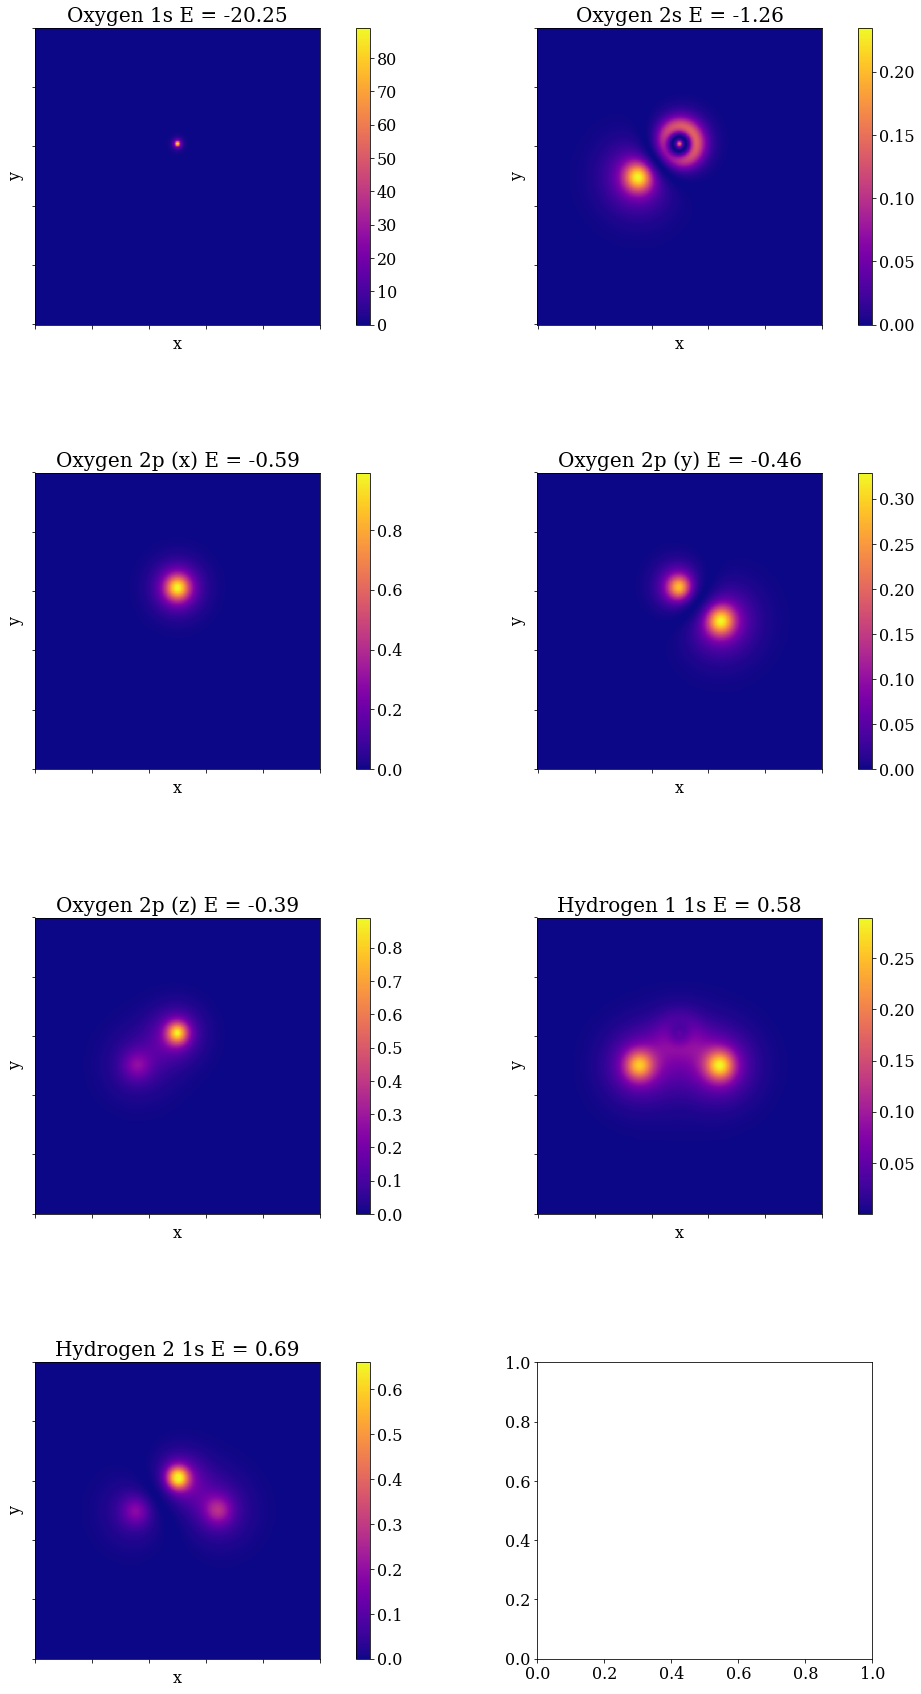

In [31]:
# plot the orbitals using a colourmap
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

# plotting the square of the wavefunction
for i in range(n_orbitals):
    im = ax[i].imshow(MO[i, :, :] ** 2, cmap=plt.cm.plasma, aspect='auto', 
                      origin='lower')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.5)
    fig.colorbar(im, cax=cax)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].axes.xaxis.set_ticklabels([])
    ax[i].axes.yaxis.set_ticklabels([])
    ax[i].set_title(subplot_titles[i], fontsize=20)

plt.show()

We can see that the probabilty for they hydrogen atoms has the same regions, but the probabilities for the Hydrogen 2 atom are lower around the hydrogen nuclei than in the Hydrogen 1 orbital.

# Appendix - Changing the tolerence to see what happens...

In [27]:
# calculate the energy of the system and MO coefficents
E, C, OE = HF_iteration(S, H, G, np.zeros_like(H), Vnn, Nelectrons, tol=1e-6)
n_orbitals = C.shape[0]

# create x-y plane of points
n_points = 500
x = np.linspace(-5, 5, n_points)
y = np.linspace(-5, 5, n_points)
X, Y = np.meshgrid(x, y)

# calculate the value of the MO function at each point in space
MO = np.zeros((n_orbitals, n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        r = np.array([X[i, j], Y[i, j], 0])
        MO[:, i, j] = molecular_orbits(C, r)

Total energy: -74.966 Hartrees
Iterations: 18


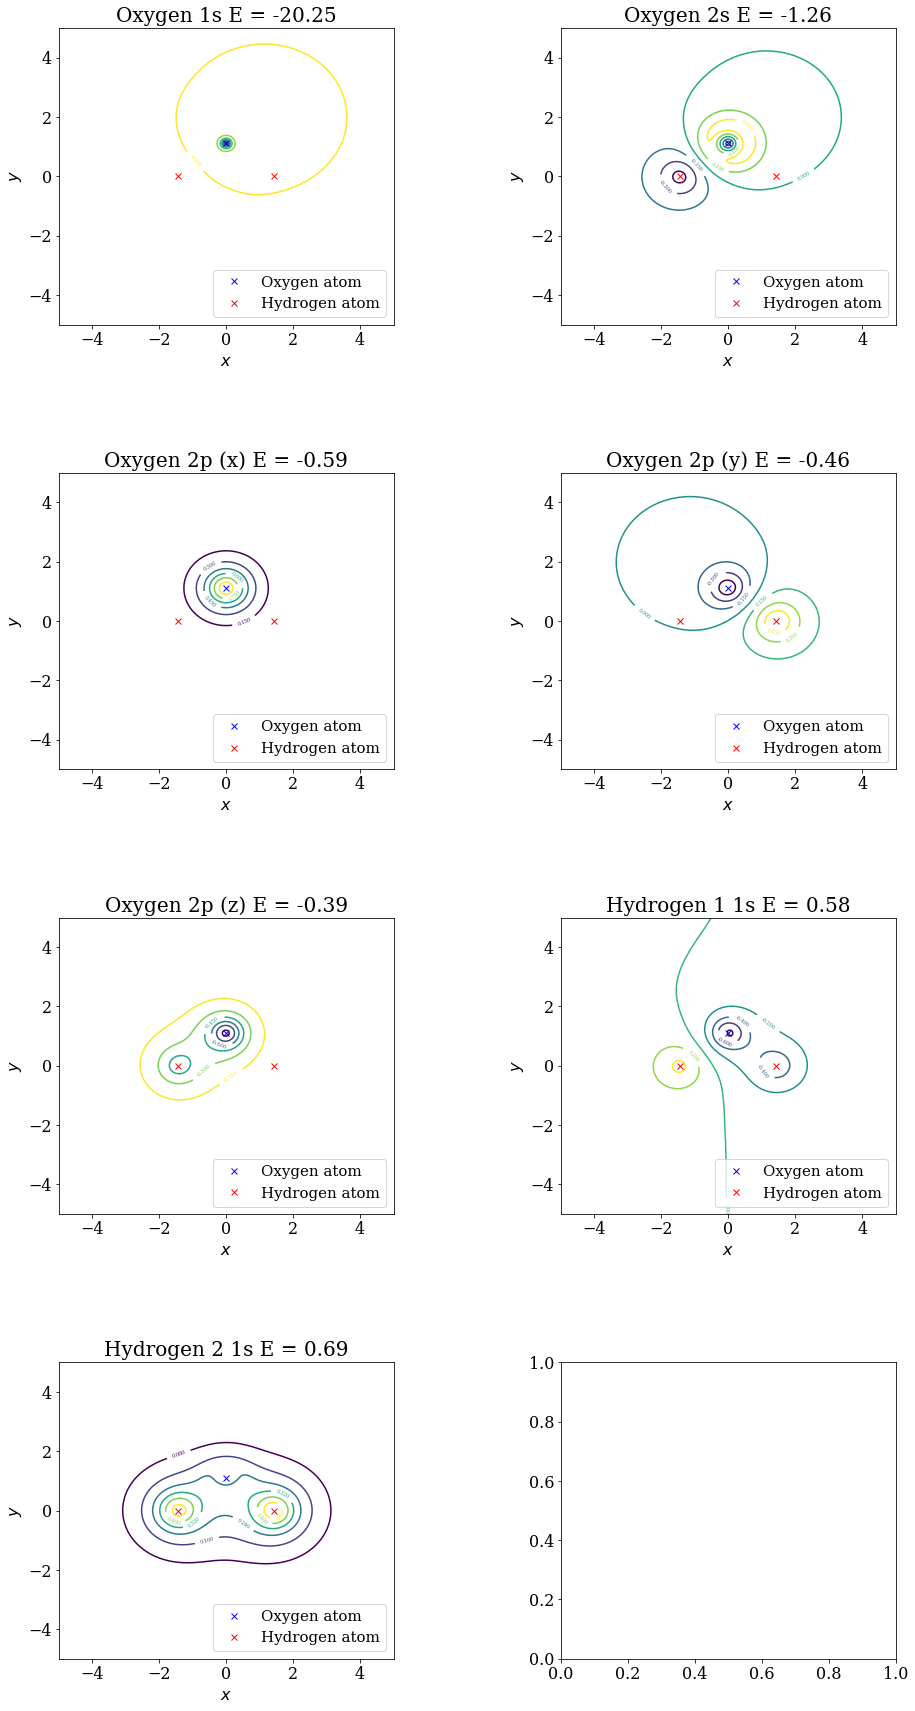

In [28]:
# define the nuclei positions for plotting and the subplot titles
R_O1 = np.array([0.0, +1.809 * np.cos(104.52/180.0 * np.pi/2.0), 0.0])
R_H1 = np.array([-1.809 * np.sin(104.52/180.0 * np.pi/2.0), 0.0, 0.0])
R_H2 = np.array([+1.809 * np.sin(104.52/180.0 * np.pi/2.0), 0.0, 0.0])
subplot_titles = ['Oxygen 1s E = {:1.2f}'.format(OE[0]),
                  'Oxygen 2s E = {:1.2f}'.format(OE[1]),
                  'Oxygen 2p (x) E = {:1.2f}'.format(OE[2]),
                  'Oxygen 2p (y) E = {:1.2f}'.format(OE[3]),
                  'Oxygen 2p (z) E = {:1.2f}'.format(OE[4]),
                  'Hydrogen 1 1s E = {:1.2f}'.format(OE[5]),
                  'Hydrogen 2 1s E = {:1.2f}'.format(OE[6])]

# plot the orbitals using a contour plot
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

for i in range(n_orbitals):
    ax[i].plot(R_O1[0], R_O1[1], 'bx', label='Oxygen atom')
    ax[i].plot(R_H1[0], R_H1[1], 'rx', label='Hydrogen atom')
    ax[i].plot(R_H2[0], R_H1[1], 'rx')
    CS = ax[i].contour(X, Y, MO[i, :, :])
    plt.clabel(CS, ax=ax[i], fontsize=5)
    ax[i].set_xlabel(r'$x$')
    ax[i].set_ylabel(r'$y$')
    ax[i].legend(loc='lower right', prop={'size': 15})
    ax[i].set_title(subplot_titles[i], fontsize=20)

plt.show()

Mysteriously, when the tolerance of the Hartree-Fock iterations is changed from $10^{-10}$ to $10^{-6}$, the orbitals of Hydrogen 1 and Hydrogen 2 swap.